# PURPOSE OF THIS NOTEBOOK:
Analyze and determine how much of a gap there is between Max and his second teammate since 2022. This will test my hypothesis that the issues that Checo were facing were a car issue and not an issue of his skill. 

In [1]:
import pandas as pd
import numpy as np
import fastf1
import fastf1.plotting
import matplotlib as mpl
import datetime
import timedelta

from scipy import stats
from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection

## Possible other analysis:
1. Compare rookie driver confidence before and after crash

In [2]:
# Setting consistant variables
year = 2025
wknd = 3
ses = 'Q'
VER = 'VER'
LAW = 'TSU'
HAD = 'HAD'
colormap = mpl.cm.turbo

In [3]:
# Doing a test run to plot 
session = fastf1.get_session(year, wknd, ses)
session.load()
weekend = session.event

MaxLap = session.laps.pick_drivers(VER).pick_fastest()
LawLap = session.laps.pick_drivers(LAW).pick_fastest()
HadLap = session.laps.pick_drivers(HAD).pick_fastest()

# Get the telemetry for max
VER_x = MaxLap.telemetry['X']
VER_y = MaxLap.telemetry['Y']
VER_color = MaxLap.telemetry['Speed']
VER_laptime = MaxLap.telemetry[-1:]
VER_td = timedelta.Timedelta(MaxLap['LapTime'])

# Get telemetry for liam
LAW_x = LawLap.telemetry['X']
LAW_y = LawLap.telemetry['Y']
LAW_color = LawLap.telemetry['Speed']
LAW_laptime = LawLap.telemetry[-1:]
LAW_td = timedelta.Timedelta(LawLap['LapTime'])

req         WARNING 	DEFAULT CACHE ENABLED! (1.58 GB) /home/omah/.cache/fastf1
core           INFO 	Loading data for Japanese Grand Prix - Qualifying [v3.5.3]
req            INFO 	No cached data found for session_info. Loading data...
_api           INFO 	Fetching session info data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for track_status_data. Loading data...
_api           INFO 	Fetching track status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for _extended_timing_data. Loading data...
_api           INFO 	Fetching

In [4]:
VER_points = np.array([VER_x, VER_y]).T.reshape(-1, 1, 2)
VER_segments = np.concatenate([VER_points[:-1], VER_points[1:]], axis=1)

LAW_points = np.array([LAW_x, LAW_y]).T.reshape(-1, 1, 2)
LAW_segments = np.concatenate([LAW_points[:-1], LAW_points[1:]], axis=1)

In [5]:
# Turn it into a function:
def plot_fastest_lap(segments, lap, color, weekend, driver, laptime):
    fig, ax = plt.subplots(sharex=True, sharey=True, figsize=(12, 6.75))
    plt.title(f'{driver} time: {laptime.total.minutes}:{laptime.total.seconds}',
                size=24, loc='right')
    plt.title(f'{weekend.name} {year} - {driver} - Throttle', size=24, loc='left')


    # Adjust margins and turn of axis
    plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.12)
    ax.axis('off')


    # After this, we plot the data itself.
    # Create background track line
    ax.plot(lap.telemetry['X'], lap.telemetry['Y'],
            color='black', linestyle='-', linewidth=16, zorder=0)

    # Create a continuous norm to map from data points to colors
    norm = plt.Normalize(color.min(), color.max())
    lc = LineCollection(segments, cmap=colormap, norm=norm,
                        linestyle='-', linewidth=5)

    # Set the values used for colormapping
    lc.set_array(color)

    # Merge all line segments together
    line = ax.add_collection(lc)


    # Finally, we create a color bar as a legend.
    cbaxes = fig.add_axes([0.25, 0.05, 0.5, 0.05])
    normlegend = mpl.colors.Normalize(vmin=color.min(), vmax=color.max())
    legend = mpl.colorbar.ColorbarBase(cbaxes, norm=normlegend, cmap=colormap,
                                    orientation="horizontal")


    # Show the plot
    plt.show()
    print(f"{driver} time: {laptime.total.minutes}:{laptime.total.seconds}")

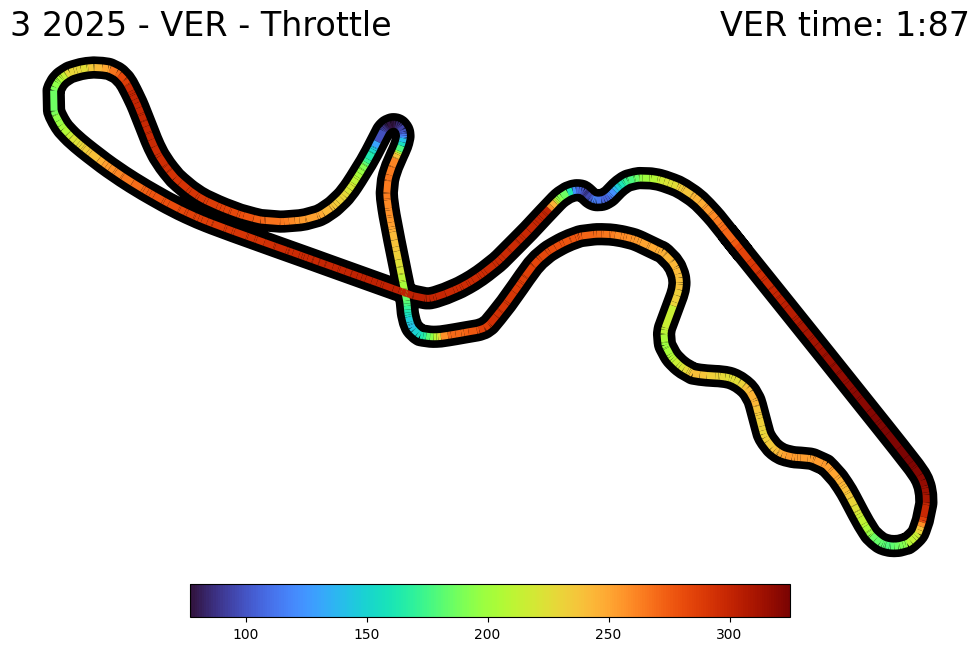

VER time: 1:87


In [6]:
# Plot Max's lap
plot_fastest_lap(VER_segments, MaxLap, VER_color, weekend, VER, VER_td)

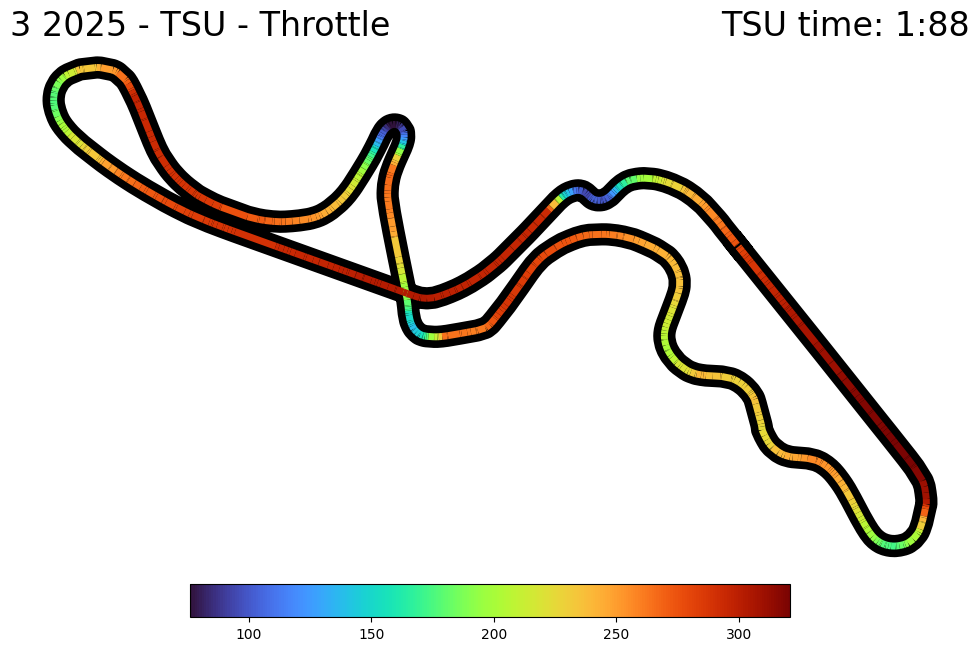

TSU time: 1:88


In [7]:
# now for lawson
plot_fastest_lap(LAW_segments, LawLap, LAW_color, weekend, LAW, LAW_td)


req            INFO 	Using cached data for driver_info


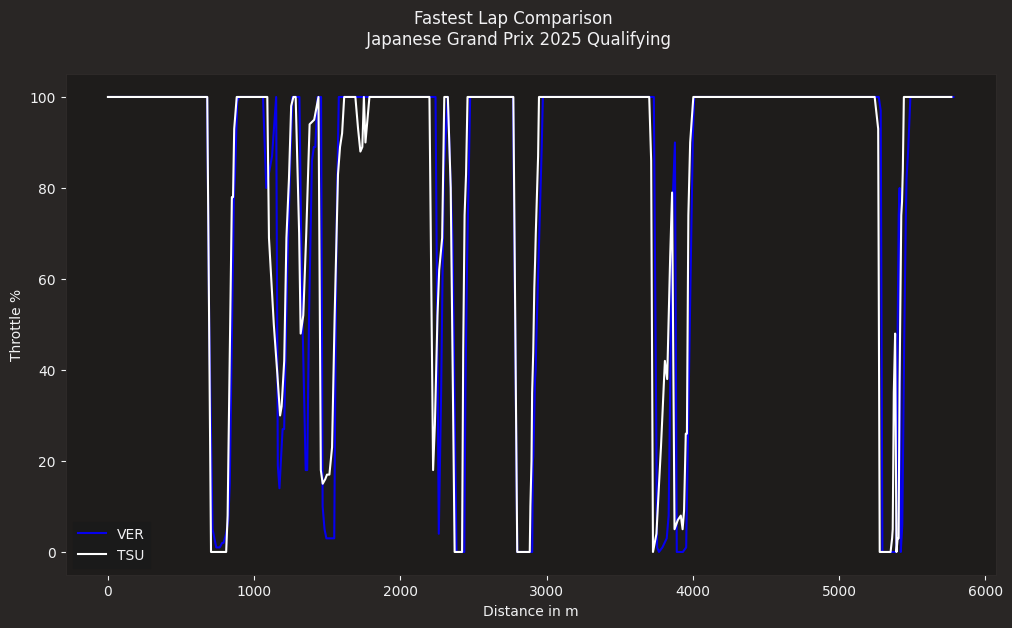

In [8]:
fastf1.plotting.setup_mpl(mpl_timedelta_support=True, misc_mpl_mods=False,
                          color_scheme='fastf1')

VER_tel = MaxLap.get_car_data().add_distance()
LAW_tel = LawLap.get_car_data().add_distance()

rbr_color = fastf1.plotting.get_team_color(MaxLap['Team'], session=session)
vcarb_color = fastf1.plotting.get_team_color(HadLap['Team'], session=session)

fig, ax = plt.subplots(figsize=(12,6.5))
ax.plot(VER_tel['Distance'], VER_tel['Throttle'], color=rbr_color, label=VER)
ax.plot(LAW_tel['Distance'], LAW_tel['Throttle'], color='white', label=LAW)

ax.set_xlabel('Distance in m')
ax.set_ylabel('Throttle %')

ax.legend()
plt.suptitle(f"Fastest Lap Comparison \n "
             f"{session.event['EventName']} {session.event.year} Qualifying")

plt.show()

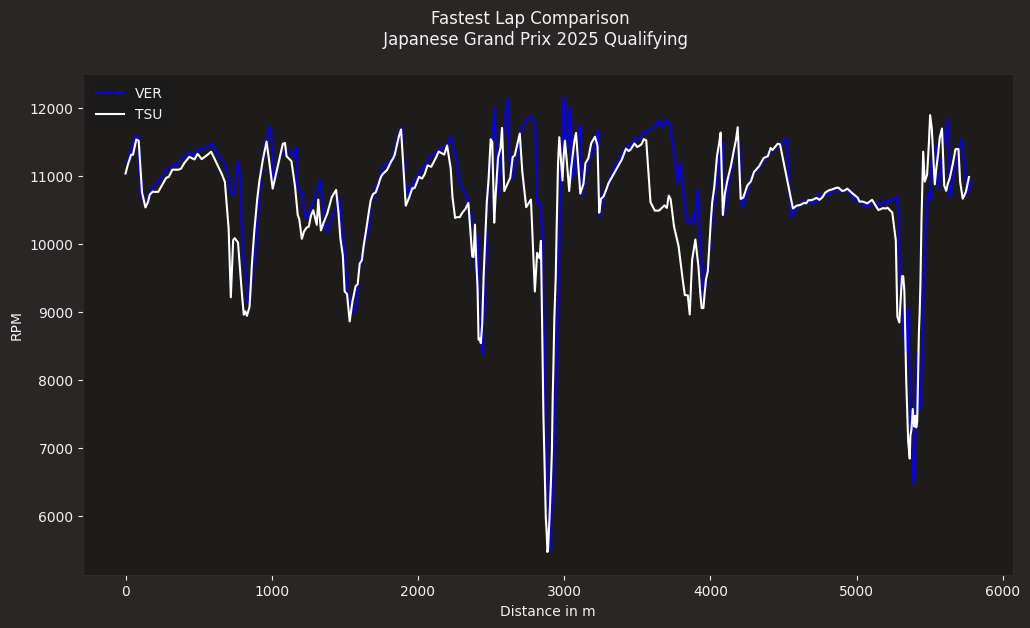

In [9]:
fastf1.plotting.setup_mpl(mpl_timedelta_support=True, misc_mpl_mods=False,
                          color_scheme='fastf1')

VER_tel = MaxLap.get_car_data().add_distance()
LAW_tel = LawLap.get_car_data().add_distance()

rbr_color = fastf1.plotting.get_team_color(MaxLap['Team'], session=session)
vcarb_color = fastf1.plotting.get_team_color(HadLap['Team'], session=session)

fig, ax = plt.subplots(figsize=(12,6.5))
ax.plot(VER_tel['Distance'], VER_tel['RPM'], color=rbr_color, label=VER)
ax.plot(LAW_tel['Distance'], LAW_tel['RPM'], color='white', label=LAW)

ax.set_xlabel('Distance in m')
ax.set_ylabel('RPM')

ax.legend()
plt.suptitle(f"Fastest Lap Comparison \n "
             f"{session.event['EventName']} {session.event.year} Qualifying")

plt.show()


## MY HYPOTHESIS
The issues that Checo and Liam were facing driving the redbull were a car issue and not a driver issue. 

### HOW WOULD I PROVE THAT
I would need to control for driver skill as much as possible. We're looking for evidence of variation between the two drivers. One way to set a baseline is to compare variations between two drivers on multiple teams. Of course some teams will have pairings that are biased as well, though we can use those pairings, espeically if the gap is more on driver skill than car unpredictibility, to help showcase and validate the hypothesis

core           INFO 	Loading data for Monaco Grand Prix - Race [v3.5.3]
req            INFO 	No cached data found for session_info. Loading data...
_api           INFO 	Fetching session info data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for lap_count. Loading data...
_api           INFO 	Fetching lap count data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for track_status_data. Loading data...
_api           INFO 	Fetching track status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cac

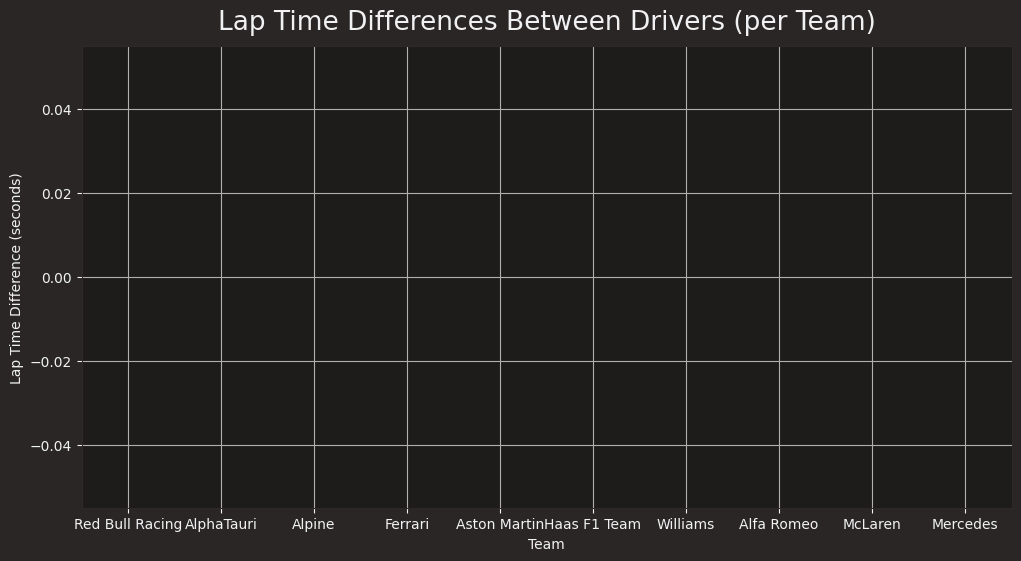

In [10]:
# TODO: loop through races to create larger datasets and more concrete plots.
# import 1 race, change to loop to compare multiple races overtime
race = fastf1.get_session(2022, 'Monaco', 'R')
race.load()

# Make a list of all the teams 
Teams = race.laps['Team'].unique().tolist()
# Box plot between two drivers in Monaco
# TODO: Change to loop to showcase all races. 
team_differences = {}

# Convert time delta to seconds 
race.laps['LapTime'] = race.laps['LapTime'].map(lambda x: datetime.timedelta.total_seconds(x) if (np.all(pd.notnull(x))) else np.nan)
for team in Teams:
    drivers = race.laps[race.laps['Team'] == team].Driver.unique()
    # Pull drivers and laps
    driver1 = drivers[0]
    driver2= drivers[1]
    driver1_laps = race.laps[race.laps['Driver'] == driver1].copy()
    driver2_laps = race.laps[race.laps['Driver'] == driver2].copy()

    # filter to only laps where both drivers completed 
    common_laps = np.intersect1d(driver1_laps['LapNumber'], driver2_laps['LapNumber'])

    driver1_common_laps = driver1_laps[driver1_laps['LapNumber'].isin(common_laps)]
    driver2_common_laps = driver2_laps[driver2_laps['LapNumber'].isin(common_laps)]

    # Calculate  the lap time differences
    lap_time_diffs = driver1_common_laps['LapTime'].values - driver2_common_laps['LapTime'].values

    team_differences[team] = lap_time_diffs

    
# Prepare data for the box plot
box_plot_data = []
team_names = []
for team, diffs in team_differences.items():
    box_plot_data.append(diffs)
    team_names.append(team)

# Create the box plot
plt.figure(figsize=(12, 6))
plt.boxplot(box_plot_data, tick_labels=team_names, showmeans=True)
plt.title("Lap Time Differences Between Drivers (per Team)")
plt.xlabel("Team")
plt.ylabel("Lap Time Difference (seconds)")
plt.grid(True)
plt.show()


## quick run down of the box plot 
Box plot maps out the differences between two drivers of each team. looking at the mean and spread, if it goes towards the negative, it would mean the second driver is slower, if it more towards positive it would imply that the first driver is much slower. for Monaco, Sergio was slower more on average than Max with a huge spread, other teams are much more close with a mean much more close than zero. 

In [11]:
# Define a list of years we want to work with 
years = [2024]

In [ ]:
all_team_differences = {}
for year in years:
    print(year)
    schedule_raw = fastf1.get_event_schedule(year).copy()
    # remove testing events
    schedule_filtered = schedule_raw[schedule_raw['EventFormat'] != 'testing']
    # Save as a list
    schedule_list = schedule_filtered['RoundNumber'].tolist()
    team_differences = {}
    for races in schedule_list:
        print(races)
        try:
            # Get the session information
            race = fastf1.get_session(year, races, 'R')
            race.load()
            # Define the teams that particapate in a race 
            Teams = race.laps['Team'].unique().tolist()
            # Copy to not modify the original
            race_laps = race.laps.copy()

            # convert time delta to seconds 
            race_laps['LapTime'] = race_laps['LapTime'].map(lambda x: datetime.timedelta.total_seconds(x) if (np.all(pd.notnull(x))) else np.nan)

            # loop through the teams
            for team in Teams:
                # get the drivers
                drivers = race_laps[race_laps['Team'] == team].Driver.unique()
                if len(drivers) < 2:
                    print(f"Team {team} in {race}, {year} has fewer than two drivers, Skipping.")
                driver1 = drivers[0]
                driver2 = drivers[1]
                # Get their laps
                driver1_laps = race_laps[race_laps['Driver'] == driver1].copy()
                driver2_laps = race_laps[race_laps['Driver'] == driver2].copy()
                
                # filter to only laps where both drivers completed 
                common_laps = np.intersect1d(driver1_laps['LapNumber'], driver2_laps['LapNumber'])

                driver1_common_laps = driver1_laps[driver1_laps['LapNumber'].isin(common_laps)]
                driver2_common_laps = driver2_laps[driver2_laps['LapNumber'].isin(common_laps)]
                
                # Calculate  the lap time differences
                lap_time_diffs = driver1_common_laps['LapTime'].values - driver2_common_laps['LapTime'].values

                if team not in all_team_differences:
                    all_team_differences[team] = []
                all_team_differences[team].extend(lap_time_diffs)
            
            # Clear cache after
            fastf1.Cache.clear_cache()

        except Exception as e:
            print(f"Error processing {year}, {session}: {e}")




2024


core           INFO 	Loading data for Bahrain Grand Prix - Race [v3.5.3]
req            INFO 	No cached data found for session_info. Loading data...
_api           INFO 	Fetching session info data...


1


req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for lap_count. Loading data...
_api           INFO 	Fetching lap count data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for track_status_data. Loading data...
_api           INFO 	Fetching track status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for _extended_timing_data. Loading data...
_api           INFO 	Fetching timing data...
_api           INFO 	Parsing timing data...
req            INFO 	Data has been written to cache!

2


req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for lap_count. Loading data...
_api           INFO 	Fetching lap count data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for track_status_data. Loading data...
_api           INFO 	Fetching track status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for _extended_timing_data. Loading data...
_api           INFO 	Fetching timing data...
_api           INFO 	Parsing timing data...
_api        WARNING 	Failed to align laps for driver

3


req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for lap_count. Loading data...
_api           INFO 	Fetching lap count data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for track_status_data. Loading data...
_api           INFO 	Fetching track status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for _extended_timing_data. Loading data...
_api           INFO 	Fetching timing data...
_api           INFO 	Parsing timing data...
req            INFO 	Data has been written to cache!

Team Williams in 2024 Season Round 3: Australian Grand Prix - Race, 2024 has fewer than two drivers, Skipping.
Error processing 2024, 2025 Season Round 3: Japanese Grand Prix - Qualifying: index 1 is out of bounds for axis 0 with size 1
4


req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for lap_count. Loading data...
_api           INFO 	Fetching lap count data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for track_status_data. Loading data...
_api           INFO 	Fetching track status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for _extended_timing_data. Loading data...
_api           INFO 	Fetching timing data...
_api           INFO 	Parsing timing data...
req            INFO 	Data has been written to cache!

5


req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for lap_count. Loading data...
_api           INFO 	Fetching lap count data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for track_status_data. Loading data...
_api           INFO 	Fetching track status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for _extended_timing_data. Loading data...
_api           INFO 	Fetching timing data...
_api           INFO 	Parsing timing data...
req            INFO 	Data has been written to cache!

6


req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for lap_count. Loading data...
_api           INFO 	Fetching lap count data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for track_status_data. Loading data...
_api           INFO 	Fetching track status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for _extended_timing_data. Loading data...
_api           INFO 	Fetching timing data...
_api           INFO 	Parsing timing data...
req            INFO 	Data has been written to cache!

7


req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for lap_count. Loading data...
_api           INFO 	Fetching lap count data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for track_status_data. Loading data...
_api           INFO 	Fetching track status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for _extended_timing_data. Loading data...
_api           INFO 	Fetching timing data...
_api           INFO 	Parsing timing data...
req            INFO 	Data has been written to cache!

8


req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for lap_count. Loading data...
_api           INFO 	Fetching lap count data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for track_status_data. Loading data...
_api           INFO 	Fetching track status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for _extended_timing_data. Loading data...
_api           INFO 	Fetching timing data...
_api           INFO 	Parsing timing data...
req            INFO 	Data has been written to cache!

9


req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for lap_count. Loading data...
_api           INFO 	Fetching lap count data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for track_status_data. Loading data...
_api           INFO 	Fetching track status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for _extended_timing_data. Loading data...
_api           INFO 	Fetching timing data...
_api           INFO 	Parsing timing data...
req            INFO 	Data has been written to cache!

10


req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for lap_count. Loading data...
_api           INFO 	Fetching lap count data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for track_status_data. Loading data...
_api           INFO 	Fetching track status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for _extended_timing_data. Loading data...
_api           INFO 	Fetching timing data...
_api           INFO 	Parsing timing data...
req            INFO 	Data has been written to cache!

11


req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for lap_count. Loading data...
_api           INFO 	Fetching lap count data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for track_status_data. Loading data...
_api           INFO 	Fetching track status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for _extended_timing_data. Loading data...
_api           INFO 	Fetching timing data...
_api           INFO 	Parsing timing data...
req            INFO 	Data has been written to cache!

12


req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for lap_count. Loading data...
_api           INFO 	Fetching lap count data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for track_status_data. Loading data...
_api           INFO 	Fetching track status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for _extended_timing_data. Loading data...
_api           INFO 	Fetching timing data...
_api           INFO 	Parsing timing data...
req            INFO 	Data has been written to cache!

13


req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for lap_count. Loading data...
_api           INFO 	Fetching lap count data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for track_status_data. Loading data...
_api           INFO 	Fetching track status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for _extended_timing_data. Loading data...
_api           INFO 	Fetching timing data...
_api           INFO 	Parsing timing data...
req            INFO 	Data has been written to cache!

14


req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for lap_count. Loading data...
_api           INFO 	Fetching lap count data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for track_status_data. Loading data...
_api           INFO 	Fetching track status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for _extended_timing_data. Loading data...
_api           INFO 	Fetching timing data...
_api           INFO 	Parsing timing data...
req            INFO 	Data has been written to cache!

15


req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for lap_count. Loading data...
_api           INFO 	Fetching lap count data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for track_status_data. Loading data...
_api           INFO 	Fetching track status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for _extended_timing_data. Loading data...
_api           INFO 	Fetching timing data...
_api           INFO 	Parsing timing data...
req            INFO 	Data has been written to cache!

16


req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for lap_count. Loading data...
_api           INFO 	Fetching lap count data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for track_status_data. Loading data...
_api           INFO 	Fetching track status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for _extended_timing_data. Loading data...
_api           INFO 	Fetching timing data...
_api           INFO 	Parsing timing data...
req            INFO 	Data has been written to cache!

17


req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for lap_count. Loading data...
_api           INFO 	Fetching lap count data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for track_status_data. Loading data...
_api           INFO 	Fetching track status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for _extended_timing_data. Loading data...
_api           INFO 	Fetching timing data...
_api           INFO 	Parsing timing data...
req            INFO 	Data has been written to cache!

18


req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for lap_count. Loading data...
_api           INFO 	Fetching lap count data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for track_status_data. Loading data...
_api           INFO 	Fetching track status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for _extended_timing_data. Loading data...
_api           INFO 	Fetching timing data...
_api           INFO 	Parsing timing data...
req            INFO 	Data has been written to cache!

19


req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for lap_count. Loading data...
_api           INFO 	Fetching lap count data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for track_status_data. Loading data...
_api           INFO 	Fetching track status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for _extended_timing_data. Loading data...
_api           INFO 	Fetching timing data...
_api           INFO 	Parsing timing data...
_api        WARNING 	Failed to align laps for driver

20


req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for lap_count. Loading data...
_api           INFO 	Fetching lap count data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for track_status_data. Loading data...
_api           INFO 	Fetching track status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for _extended_timing_data. Loading data...
_api           INFO 	Fetching timing data...
_api           INFO 	Parsing timing data...
req            INFO 	Data has been written to cache!

21


req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for lap_count. Loading data...
_api           INFO 	Fetching lap count data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for track_status_data. Loading data...
_api           INFO 	Fetching track status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for _extended_timing_data. Loading data...
_api           INFO 	Fetching timing data...
_api           INFO 	Parsing timing data...
req            INFO 	Data has been written to cache!

Team Williams in 2024 Season Round 21: São Paulo Grand Prix - Race, 2024 has fewer than two drivers, Skipping.
Error processing 2024, 2025 Season Round 3: Japanese Grand Prix - Qualifying: index 1 is out of bounds for axis 0 with size 1
22


req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for lap_count. Loading data...
_api           INFO 	Fetching lap count data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for track_status_data. Loading data...
_api           INFO 	Fetching track status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for _extended_timing_data. Loading data...
_api           INFO 	Fetching timing data...
_api           INFO 	Parsing timing data...
req            INFO 	Data has been written to cache!

23


req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for lap_count. Loading data...
_api           INFO 	Fetching lap count data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for track_status_data. Loading data...
_api           INFO 	Fetching track status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for _extended_timing_data. Loading data...
_api           INFO 	Fetching timing data...
_api           INFO 	Parsing timing data...
req            INFO 	Data has been written to cache!

24


core           INFO 	Loading data for Abu Dhabi Grand Prix - Race [v3.5.3]
req            INFO 	No cached data found for session_info. Loading data...
_api           INFO 	Fetching session info data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for lap_count. Loading data...
_api           INFO 	Fetching lap count data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for track_status_data. Loading data...
_api           INFO 	Fetching track status data...
req            INFO 	Data has been written to cache!
req            INFO 	No 

<Figure size 640x480 with 0 Axes>

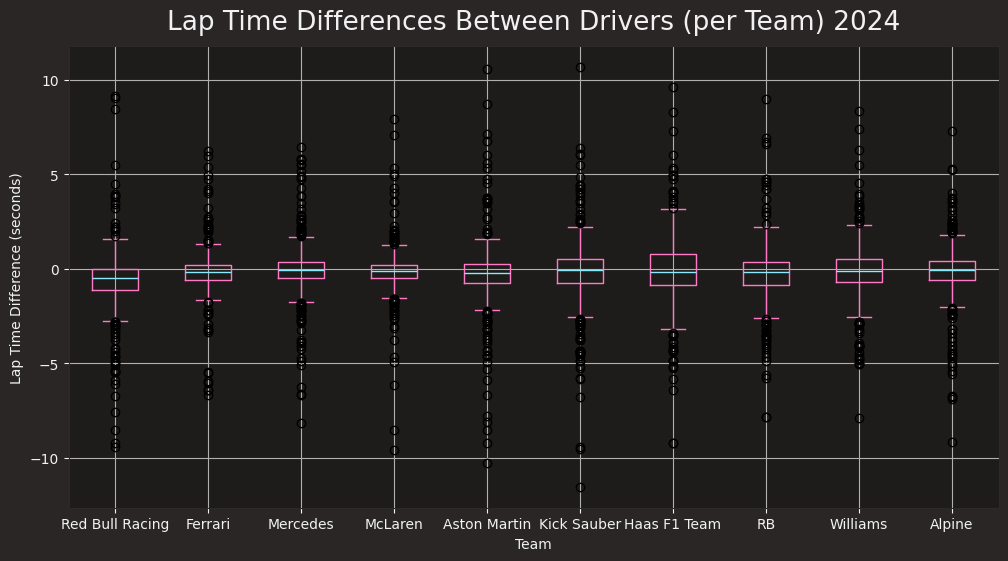

In [ ]:
# Convert to DataFrame
df = pd.DataFrame.from_dict(all_team_differences, orient='index')

# Transpose for boxplot
df_transposed = df.T

# Drop NaNs
df_transposed = df_transposed.dropna()

# Outlier Removal (using Z-score)
z = np.abs(stats.zscore(df_transposed))
# Removing Z-score over 2 
df_transposed = df_transposed[(z < 2).all(axis=1)] 

# Create Boxplot
plt.figure()
df_transposed.plot(kind='box', figsize=(12, 6))
plt.title("Lap Time Differences Between Drivers (per Team) 2024")
plt.xlabel("Team")
plt.ylabel("Lap Time Difference (seconds)")
plt.grid(True)
plt.show()


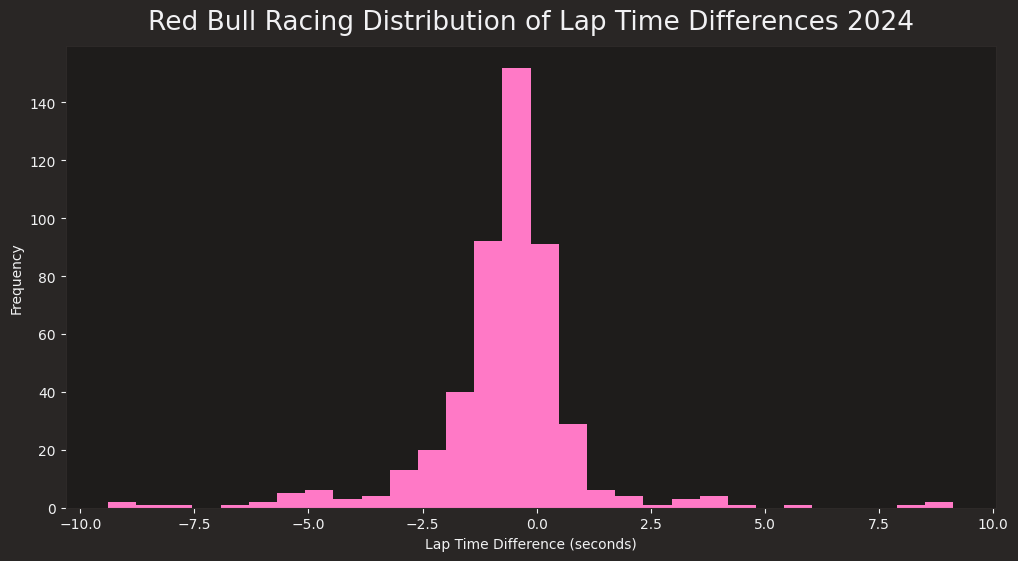

In [ ]:
# plot histogram of laptime data.
plt.figure(figsize=(12, 6))
plt.hist(df_transposed['Red Bull Racing'], bins=30)
plt.xlabel("Lap Time Difference (seconds)")
plt.ylabel("Frequency")
plt.title("Red Bull Racing Distribution of Lap Time Differences 2024") 
plt.show()

## Histogram Takeaway
**2023 season** There is a very slight skew to the left, indicating that Max does have an edge over Checo over the span of a race season. 

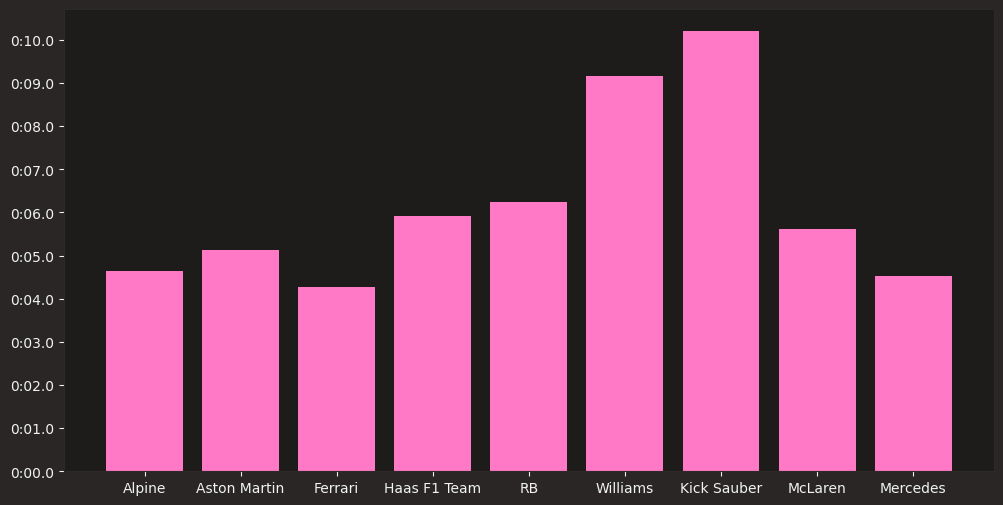

In [ ]:
# TODO: This only showcases over 1 race, Need to fix and append data over time 
# Standard deviation of lap time differences 
team_std = {}
for team in Teams:
    drivers = race.laps[race.laps['Team'] == team].Driver.unique()
    # Pull drivers and laps
    driver1 = drivers[0]
    driver2= drivers[1]
    driver1_laps = race.laps[race.laps['Driver'] == driver1].copy()
    driver2_laps = race.laps[race.laps['Driver'] == driver2].copy()

    # filter to only laps where both drivers completed 
    common_laps = np.intersect1d(driver1_laps['LapNumber'], driver2_laps['LapNumber'])   
    driver1_common_laps = driver1_laps[driver1_laps['LapNumber'].isin(common_laps)]
    driver2_common_laps = driver2_laps[driver2_laps['LapNumber'].isin(common_laps)]

    # reset index
    driver1_common_laps.reset_index(inplace=True)
    driver2_common_laps.reset_index(inplace=True)

    df = pd.DataFrame(columns=['driver1_times', 'driver2_times'])
    df['driver1_times'] = driver1_common_laps['LapTime']
    df['driver2_times'] = driver2_common_laps['LapTime']

    std_series = pd.concat([df.driver1_times, df.driver2_times])
    
    team_std[team] = std_series.std()

bar_graph_data = []
team_names = []
for team, diffs in team_std.items():
    bar_graph_data.append(diffs)
    team_names.append(team)

plt.figure(figsize=(12, 6))
plt.bar(team_names, bar_graph_data)
plt.show()


# Now checking Telemetry 

In [ ]:
# Pull from one season/race to see which data is needed to plot each visualization 
# Then collect overtime 
# using 2025 Japan 
race = fastf1.get_session(2025, 3, 'R')
race.load()


core           INFO 	Loading data for Japanese Grand Prix - Race [v3.5.3]
req            INFO 	No cached data found for session_info. Loading data...
_api           INFO 	Fetching session info data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for lap_count. Loading data...
_api           INFO 	Fetching lap count data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for track_status_data. Loading data...
_api           INFO 	Fetching track status data...
req            INFO 	Data has been written to cache!
req            INFO 	No c

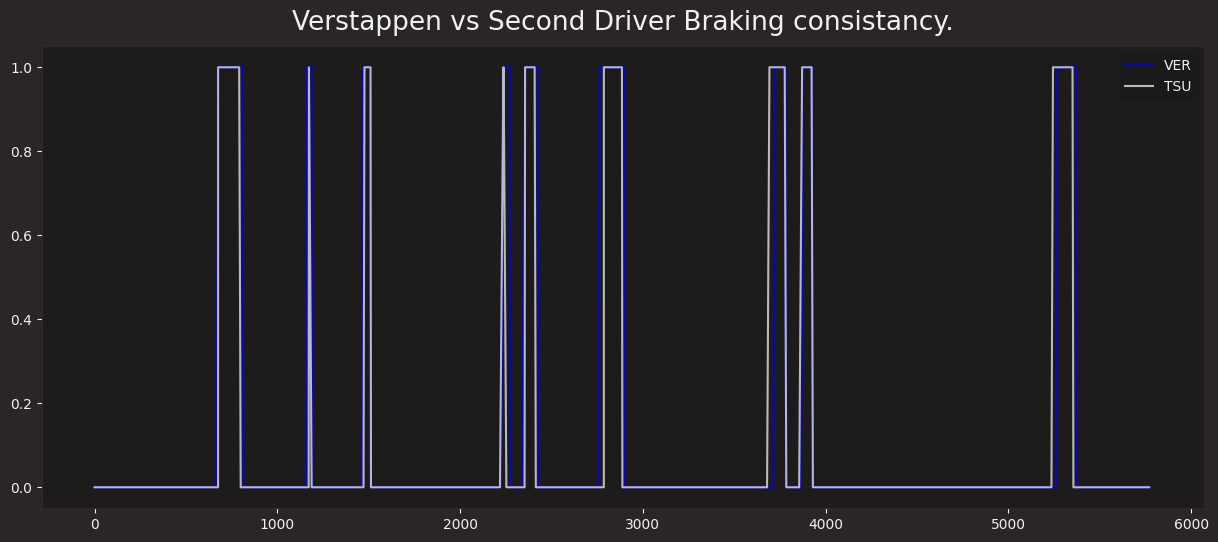

In [ ]:
# loop over multiple races 
# for race in races: 
# Grab the data needed to generate the brake plot 
race_laps = race.laps

# Filter to the drivers we want to compare 
VER = race_laps[race_laps['Driver'] == 'VER']
TSU = race_laps[race_laps['Driver'] == 'TSU']

VER_lap = VER.pick_fastest().telemetry
TSU_lap = TSU.pick_fastest().telemetry

# Plot Binary plot showing braking over distance 
fig, ax = plt.subplots() 

fig.set_figheight(6)
fig.set_figwidth(15)

ax.plot(VER_lap['Distance'], VER_lap['Brake'], label ='VER', color="blue", alpha=0.7)
ax.plot(TSU_lap['Distance'], TSU_lap['Brake'], label='TSU', color="white", alpha=0.7)
ax.set_title("Verstappen vs Second Driver Braking consistancy.")
ax.legend()

plt.show()

## Takeaway from graphing braking

Even though we don't have the % level of braking, knowing where each driver braked is extremely useful in calculating confidence. There will be some refinement as I go but I think I can calculate how confident a driver is. For simplication, I'll use the fastest Quali lap as the baseline, with the assumption that the fastest driver in qualifying is the most confident. (this is not always the case in reality, I could in the future refine this by calculating the confidence score of each driver's fastest qualifying lap and use that highest as the baseline in the future)

I could then plot all three drivers each race and see how confident each driver is. This would give us two key data points. 
1. This allows us to compare the two red bull drivers directly, allowing us to quantify and directly compare their braking confidence. 
2. Using the baseline metric also allows us to see and possibly quantify any potential lack of confidence due to the car as well. 

In [ ]:
# Grab all laps that aren't inlap/outlap or within safety car. 
VER_lap = race.laps.pick_drivers('VER').pick_accurate()
TSU_lap = race.laps.pick_drivers('TSU').pick_accurate()

In [ ]:
# Generate list of laps
TSU_lap_list = TSU_lap['LapNumber'].to_list()

In [ ]:
TSU_lap_list

[2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 20.0,
 21.0,
 22.0,
 25.0,
 26.0,
 27.0,
 28.0,
 29.0,
 30.0,
 31.0,
 32.0,
 33.0,
 34.0,
 35.0,
 36.0,
 37.0,
 38.0,
 39.0,
 40.0,
 41.0,
 42.0,
 43.0,
 44.0,
 45.0,
 46.0,
 47.0,
 48.0,
 49.0,
 50.0,
 51.0,
 52.0,
 53.0]

In [ ]:
test = TSU_lap[TSU_lap['LapNumber'] == 21].telemetry.columns

In [ ]:
def calculate_brake_consistancy(lap, lap_list):
    '''PURPOSE OF THIS FUNCTION: 
    Calculate the brake consistancy of a driver using existing telemetry data. 
    We need to calculate 2 Variable
    1. Distance traveled when Braking
    2. Average speed during the braking event
    
    Then get the time when the braking even starts and ends
    '''
    # Define final variable
    lap_cols = lap.telemetry.columns
    total_tel = pd.DataFrame(columns=lap_cols)
    for lap_number in lap_list:
        lap_tel = lap[lap['LapNumber'] == lap_number].telemetry
        lap_tel['LapNumber'] = lap_number
        # Start with distance traveled while braking
        # Group each braking zone
        # TODO: Refine the generation of brakezones, have it be correlated to each corner
        # Rather than being generated by braking events, making analysis easier and grouping 
        # more accurate to assumptions. 
        lap_tel['BrakeZone'] = lap_tel[lap_tel['Brake']].index.to_series().diff().ne(1).cumsum()

        # Calculate the total distance braked
        lap_tel['DistanceBraked'] = lap_tel.groupby('BrakeZone')['Distance'].diff().fillna(0)
        lap_tel['TotalDistanceBraked'] = lap_tel.groupby('BrakeZone')['DistanceBraked'].transform('sum')

        # Now Calculate Average Speed at braking
        lap_tel['AvgSpeedBraking'] = lap_tel.groupby('BrakeZone')['Speed'].transform('mean')

        # Calculate braking times and total laptime in seconds
        lap_tel['TotalTime'] = lap_tel['Time'].iloc[-1].total_seconds()

        brake_start_dict = {}
        brake_end_dict = {}
        for zone, group in lap_tel.groupby('BrakeZone'):
            brake_start_dict[zone] = group['Time'].min().total_seconds()
            brake_end_dict[zone] = group['Time'].max().total_seconds()
        
        lap_tel['BrakeStartTime'] = lap_tel['BrakeZone'].map(brake_start_dict)
        lap_tel['BrakeEndTime'] = lap_tel['BrakeZone'].map(brake_end_dict)

        # Normalize Braking starting and end times into percentages of the total laptime

        # append data to total telemetry. 
        total_tel = pd.concat([total_tel, lap_tel], ignore_index=True)

    return total_tel
    

In [ ]:
total_tel = calculate_brake_consistancy(TSU_lap, TSU_lap_list)

/tmp/ipykernel_7420/2449621917.py:46: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  total_tel = pd.concat([total_tel, lap_tel], ignore_index=True)


In [ ]:
total_tel.LapNumber.unique()

array([ 2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14.,
       15., 16., 17., 18., 19., 20., 21., 22., 25., 26., 27., 28., 29.,
       30., 31., 32., 33., 34., 35., 36., 37., 38., 39., 40., 41., 42.,
       43., 44., 45., 46., 47., 48., 49., 50., 51., 52., 53.])

In [ ]:
ex = TSU_lap[TSU_lap['LapNumber'] == 22].telemetry

In [ ]:
# Add the columns to our example df
lap_tel = ex
lap_tel['BrakeZone'] = lap_tel[lap_tel['Brake']].index.to_series().diff().ne(1).cumsum()

# Calculate the total distance braked
lap_tel['DistanceBraked'] = lap_tel.groupby('BrakeZone')['Distance'].diff().fillna(0)
lap_tel['TotalDistanceBraked'] = lap_tel.groupby('BrakeZone')['DistanceBraked'].transform('sum')

# Now Calculate Average Speed at braking
lap_tel['AvgSpeedBraking'] = lap_tel.groupby('BrakeZone')['Speed'].transform('mean')

In [ ]:
lap_tel['total_time'] = lap_tel['Time'].iloc[-1].total_seconds()

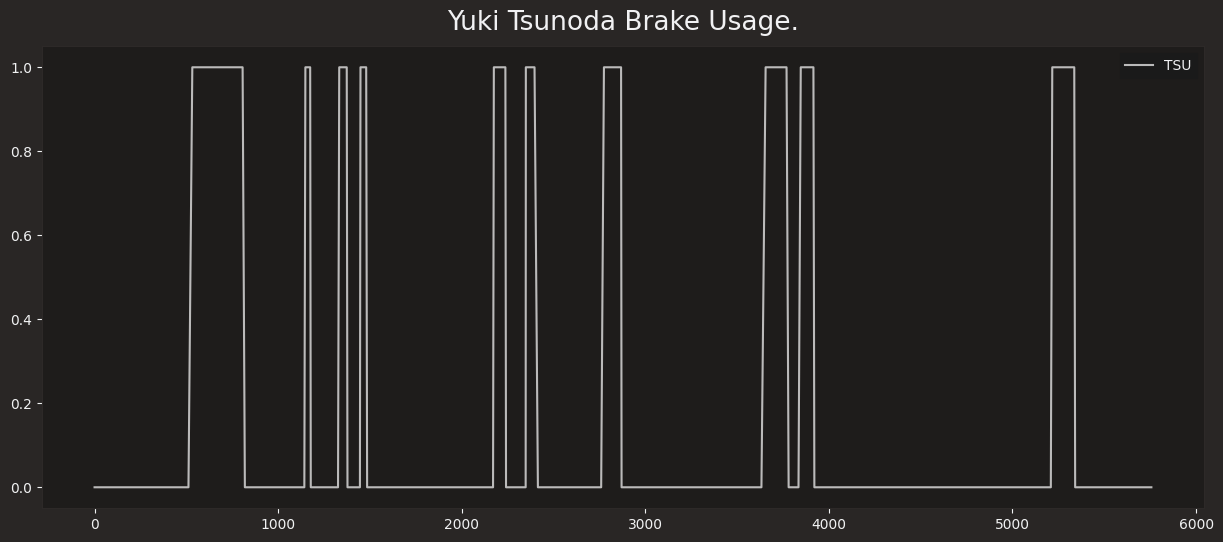

In [ ]:
# Grab the data needed to generate the brake plot 
# Add circuit data
circuit_info = race.get_circuit_info()

# Plot Binary plot showing braking over distance 
fig, ax = plt.subplots() 

fig.set_figheight(6)
fig.set_figwidth(15)

ax.vlines(x=circuit_info.corners['Distance'], ymin=0, ymax=1, linestyles="dotted", colores='grey')

# Plot corners 
for _, corner in circuit_info.corners.iterrows():
    txt = f"{corner['Number']}{corner['Letter']}"
    ax.text(corner['Distance'], 0, txt, 
            va='center_baseline', ha='center', size='small')
    
ax.plot(lap_tel['Distance'], lap_tel['Brake'], label ='TSU', color="white", alpha=0.7)
ax.set_xlabel('Distance in m')
ax.set_ylabel('Brake Trigger')
ax.set_title("Yuki Tsunoda Brake Usage.")
ax.legend()

plt.show()

<Axes: xlabel='BrakeZone'>

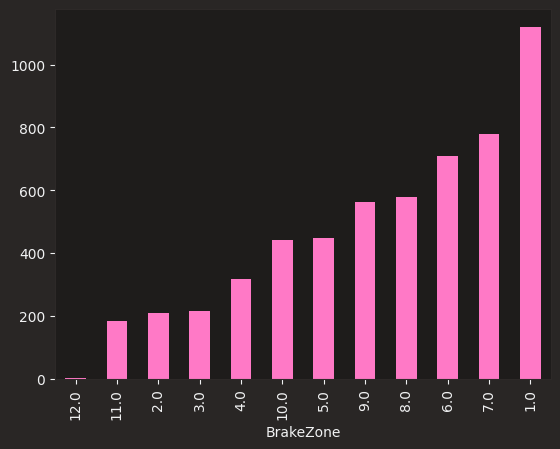

In [ ]:
# Get idea of how often each brake zone is named
total_tel.BrakeZone.value_counts().sort_values().plot(kind='bar')

In [ ]:
# Start new generation of the brake zones. 
# Would have to see how close 

# First plot braking vs corners to see which corners 

## Note about braking (2025 Japanese GP)
At first, when I saw that brake zone 7-8, 5 & 10 happen much more often than the other braking zones I first thought that there was an error in the way BrakeZone was calculated. But after checking my code and some deeper analysis, there was no actual issue with the generation of BrakeZone. The real reason is that those braking events, on average happen for longer periods of time and cover more distance, causing them to have more rows. This is shown visually in the braking graph above the function call

In [ ]:
# Look at the brakezones
lap_tel['BrakeZone'].unique()

array([nan,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.])